In [2]:
def distribution_prices():
    pass

In [133]:
def special_day_analysis(ebd):
    import pandas as pd
    import sys, os
    sys.path.append(os.path.join(os.path.dirname(''), '../..'))
    from proj2_eniac_price_discounts.src.DSBC_proj2_utils import unpack_dict, pack_dict
    products, orders, orderlines, brands = unpack_dict(ebd)
    
    #
    all_orders = orderlines.merge(orders, right_on='order_id', left_on='id_order')
    all_orders =  all_orders.assign(
            created_day = pd.to_datetime(all_orders['created_date']).dt.strftime('%-j'),
            day = pd.to_datetime(all_orders['date']).dt.strftime('%j'),
            year = pd.to_datetime(all_orders['date']).dt.strftime('%Y')
    ).query('year != "2018"')
    
    all_orders = get_discounts(all_orders, products)

    #counts the number of occurences of all states
    from collections import Counter
    def count_state_to_dict(x):
        state_dict = {
            'Cancelled': 0, 
            'Completed': 0, 
            'Pending': 0, 
            'Shopping Basket': 0, 
            'Place Order': 0
        }

        state_dict.update(Counter(x.tolist()))
        return pd.DataFrame(state_dict, index=[int(x.name) - 1])

    #multiple index resets necessary in order to put all columns together
    grpday = all_orders.groupby('day')
    all_orders_grpday_statecount = (
        grpday['state']
        .apply(count_state_to_dict)
        .reset_index()
        .drop('level_1', axis=1)
    )
    disc_col = 'discount_perc'
    all_orders_grpday_statecount.loc[:,disc_col + '_sum'] = grpday[disc_col].sum().reset_index()[disc_col]
    all_orders_grpday_statecount.loc[:,disc_col + '_avg'] = grpday[disc_col].mean().reset_index()[disc_col]
    all_orders_grpday_statecount.loc[:,disc_col + '_max'] = grpday[disc_col].max().reset_index()[disc_col]

    return all_orders_grpday_statecount

In [125]:
def corr_heatmap(df):
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot  as plt
    
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5) 

In [126]:
def get_discounts(all_orders, products):    
    import pandas as pd
    
    ol_prices = (
    all_orders                             #<------ changed
        .groupby(by=['sku',"day",'state']) #<------ changed
        .agg(
            min_ol_price=("unit_price", "min"),
            mean_ol_price=("unit_price", "mean"),
            max_ol_price=("unit_price", "max"))
        .reset_index()
    )
    ol_prices.head()
    ol_prices.mean_ol_price.isnull().sum()

    products01 = pd.merge(products, ol_prices, left_on="sku", right_on="sku", how='inner')
    
    products01["price_diff"] = products01["price"] - products01["mean_ol_price"]
    products01["discount_perc"] = 100-products01["mean_ol_price"]/products01["price"]*100
    
    return products01

In [127]:
def plot_discount_over_days(all_orders_grpday_statecount, disc_kind):
    import seaborn as sns
    g = sns.relplot(
        data=all_orders_grpday_statecount, 
        kind='line',
        x='day', 
        y='discount_perc_' + disc_kind,
        linewidth = 5,
        height=10,
        aspect=3
    )
    return g

In [128]:
def plot_orders_over_days(all_orders_grpday_statecount):
    import seaborn as sns

    g = sns.relplot(
        data=all_orders_grpday_statecount, 
        kind='line',
        x='day', 
        y=all_orders_grpday_statecount[['Cancelled','Completed','Pending','Shopping Basket','Place Order']].sum(axis = 1),
        linewidth = 5,
        height=10,
        aspect=3
    )
    return g

In [129]:
def find_conspicious_days(all_orders_grpday_statecount, disc_kind):
    disc = 'discount_perc_' + disc_kind
    large_disc_min = all_orders_grpday_statecount[disc].nlargest(10).min()
    small_disc_max = all_orders_grpday_statecount[disc].nsmallest(10).max()

    mask = (all_orders_grpday_statecount[disc] >= large_disc_min) \
            | (all_orders_grpday_statecount[disc] <= small_disc_max)

    conspicious_days = all_orders_grpday_statecount[mask]
    conspicious_days.loc[:,'date'] = pd.to_datetime(conspicious_days['day'], format='%j')
    conspicious_days.loc[:,'weekday'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.weekday
    # conspicious_days.loc[:,'dayofmonth'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.day
    # conspicious_days.loc[:,'month'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.month

    return conspicious_days

In [134]:
if True:
    import nbimporter
    import pandas as pd
    import sys, os
    sys.path.append(os.path.join(os.path.dirname(''), '../..'))
    from proj2_eniac_price_discounts.DSBC_proj2_main import load_clean_data

    ebd = load_clean_data(path = '../data/')
    all_orders_grpday_statecount = special_day_analysis(ebd)
    
    #drop rows with neg discount
    no_of_neg_rows = (all_orders_grpday_statecount['discount_perc_sum'] < 0).sum()
    idx_of_neg_rows = all_orders_grpday_statecount['discount_perc_sum'].nsmallest(no_of_neg_rows).index
    all_orders_grpday_statecount.drop(idx_of_neg_rows, inplace=True)
    
    conspicious_days_avg = find_conspicious_days(all_orders_grpday_statecount, 'avg')
    conspicious_days_sum = find_conspicious_days(all_orders_grpday_statecount, 'sum')
    conspicious_days_max = find_conspicious_days(all_orders_grpday_statecount, 'max')
    

C:\Users\circl\AppData\Local\Temp\ipykernel_9384\2646643959.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspicious_days.loc[:,'date'] = pd.to_datetime(conspicious_days['day'], format='%j')
C:\Users\circl\AppData\Local\Temp\ipykernel_9384\2646643959.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspicious_days.loc[:,'weekday'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.weekday
C:\Users\circl\AppData\Local\Temp\ipykernel_9384\2646643959.py:10: SettingWithCopyWarning: 
A value 

In [144]:
conspicious_days_avg.iloc[:, 6:].sort_values(by='discount_perc_avg')

,discount_perc_sum,discount_perc_avg,discount_perc_max,date,weekday
184,3085.304943,7.125416,77.384923,1900-07-04,2
346,8993.166760,10.127440,100.000000,1900-12-13,3
96,3222.783288,10.531972,56.629588,1900-04-07,5
111,2481.789987,10.790391,60.040000,1900-04-22,6
338,6822.866797,11.277466,66.688896,1900-12-05,2
339,5786.757601,11.619995,85.742857,1900-12-06,3
169,5034.395579,11.790154,75.896987,1900-06-19,1
335,6007.558071,11.802668,74.014803,1900-12-02,6
123,4362.704406,11.952615,62.305296,1900-05-04,4
336,6840.827188,12.043710,85.028343,1900-12-03,0


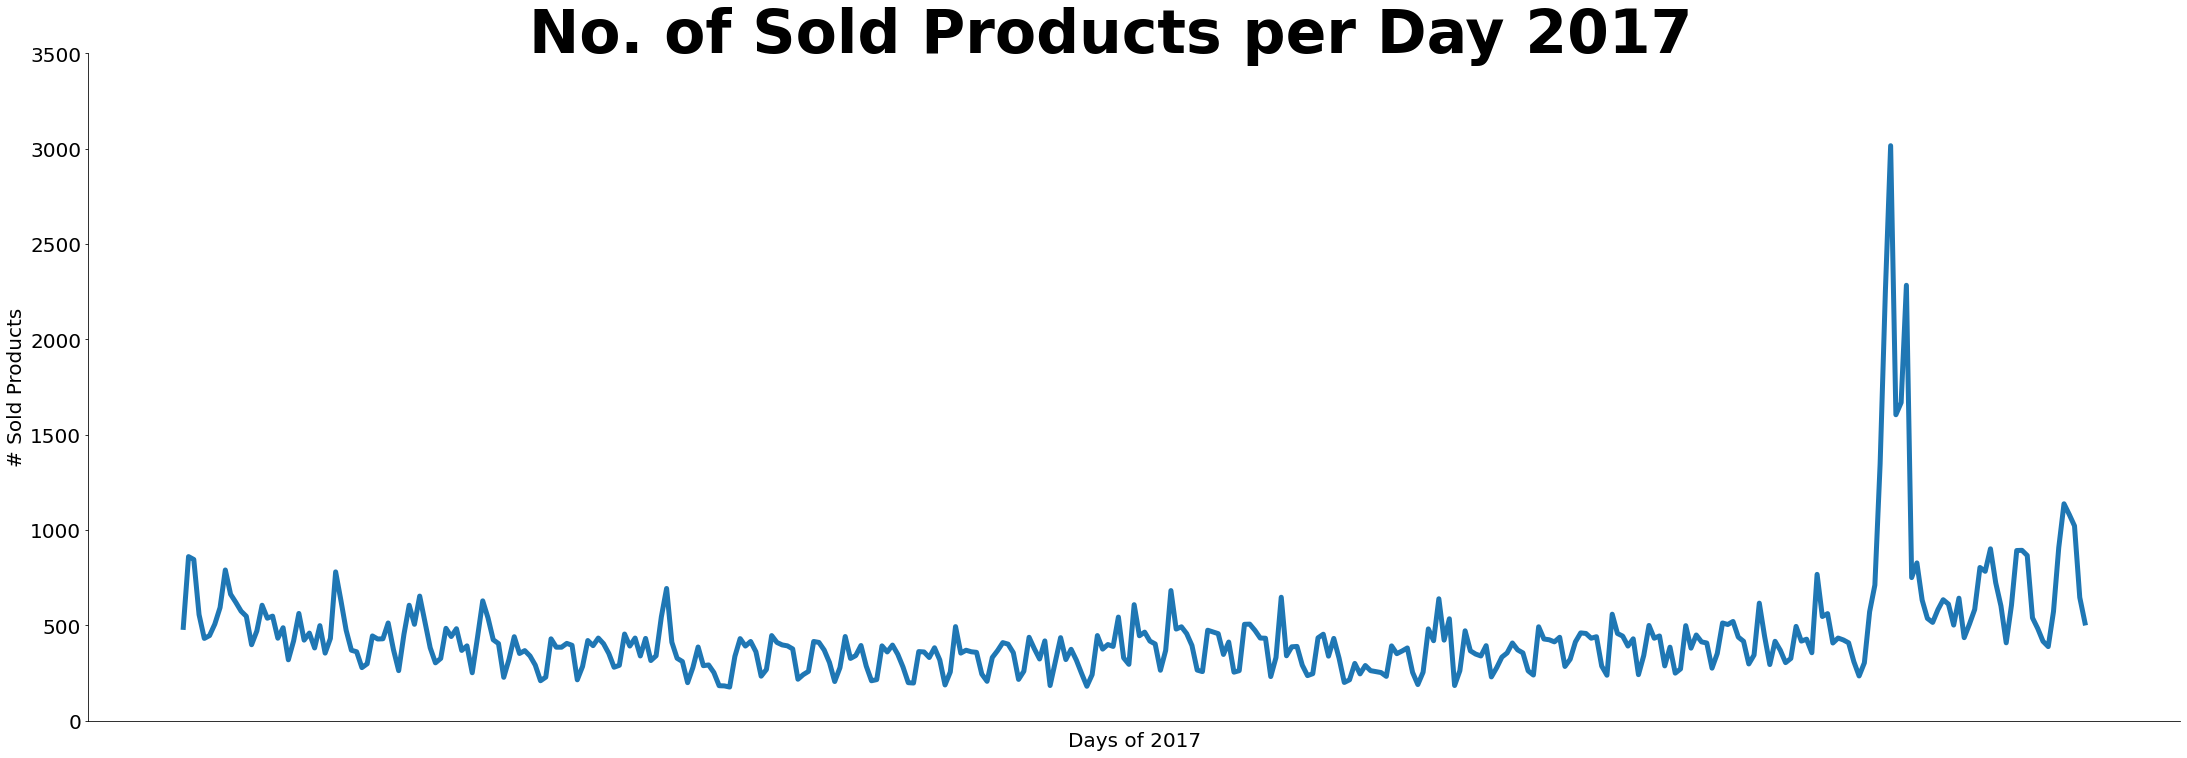

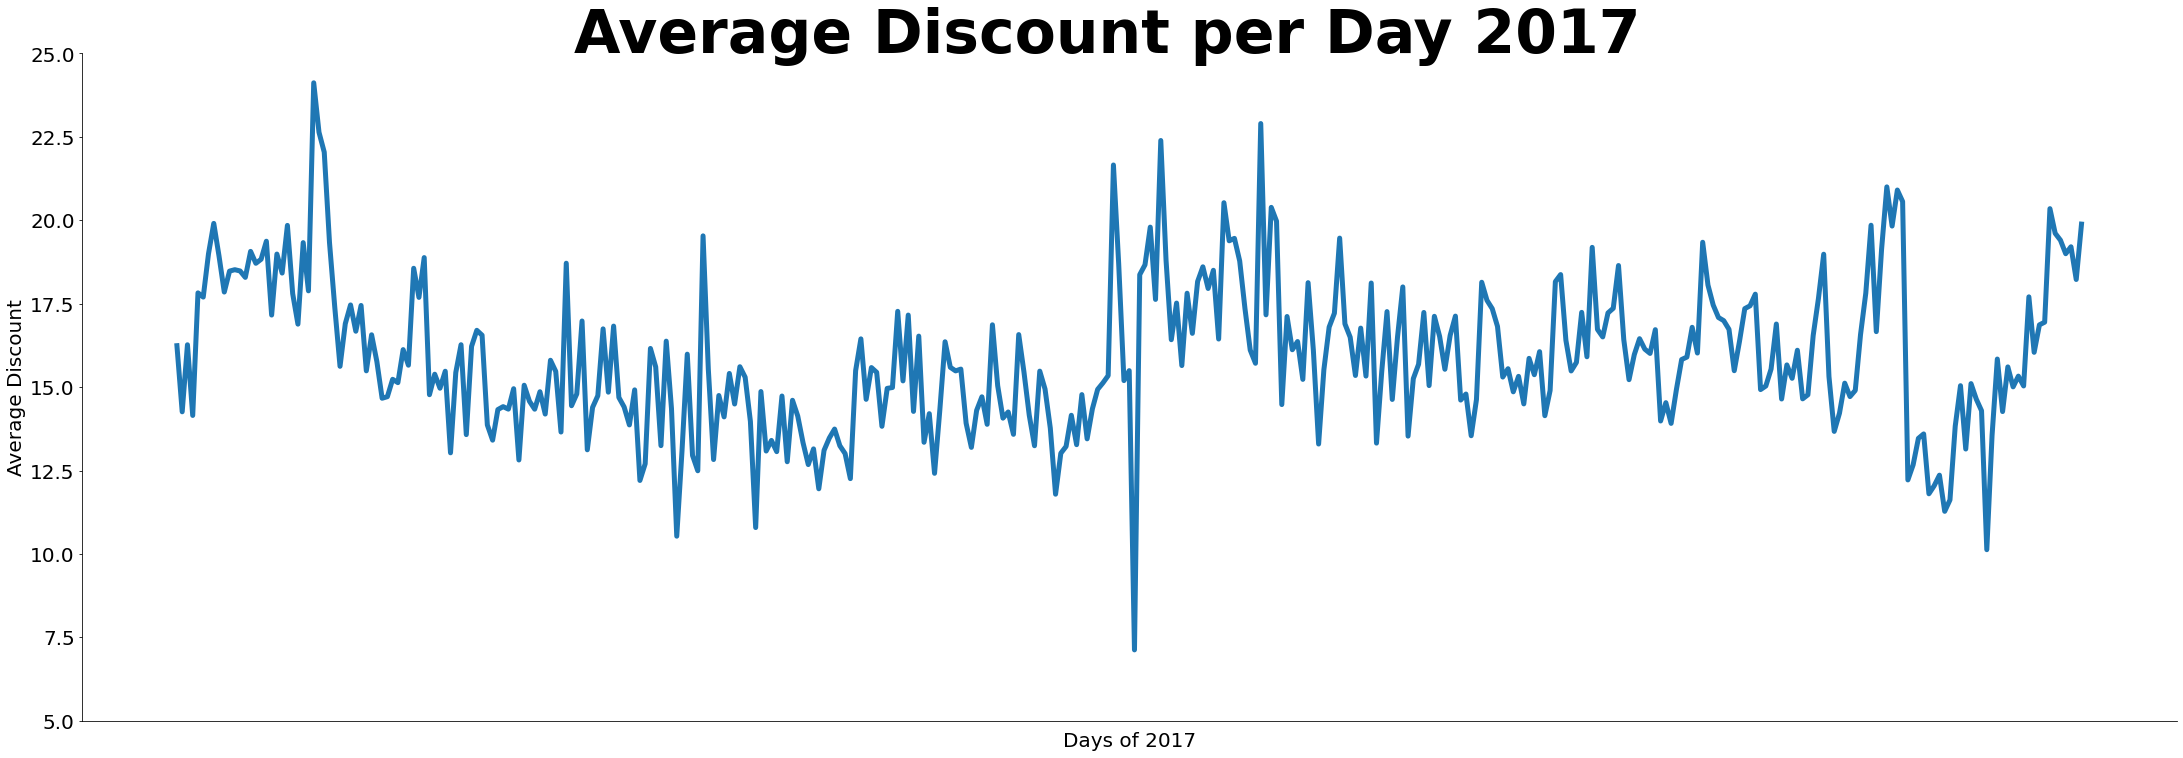

In [121]:
if True:
    #plots
    #corr_heatmap(all_orders_grpday_statecount)
    
    g = plot_orders_over_days(all_orders_grpday_statecount)
    g.fig.suptitle('No. of Sold Products per Day 2017', y=1.05, fontsize=60, fontweight='bold')
    g.set_axis_labels("Days of 2017", "# Sold Products", fontsize=20) 
    labels = pd.Series(['']*all_orders_grpday_statecount.shape[0])
    g.set_xticklabels(labels=labels)
    g.set_yticklabels(fontsize=20)
    g.fig.axes[0].tick_params(which="both", bottom=False)
    
    g = plot_discount_over_days(all_orders_grpday_statecount, 'avg')
    g.fig.suptitle('Average Discount per Day 2017', y=1.05, fontsize=60, fontweight='bold')
    g.set_axis_labels("Days of 2017", "Average Discount", fontsize=20)
    g.set_xticklabels(labels=labels)
    g.set_yticklabels(fontsize=20)
    g.fig.axes[0].tick_params(which="both", bottom=False)

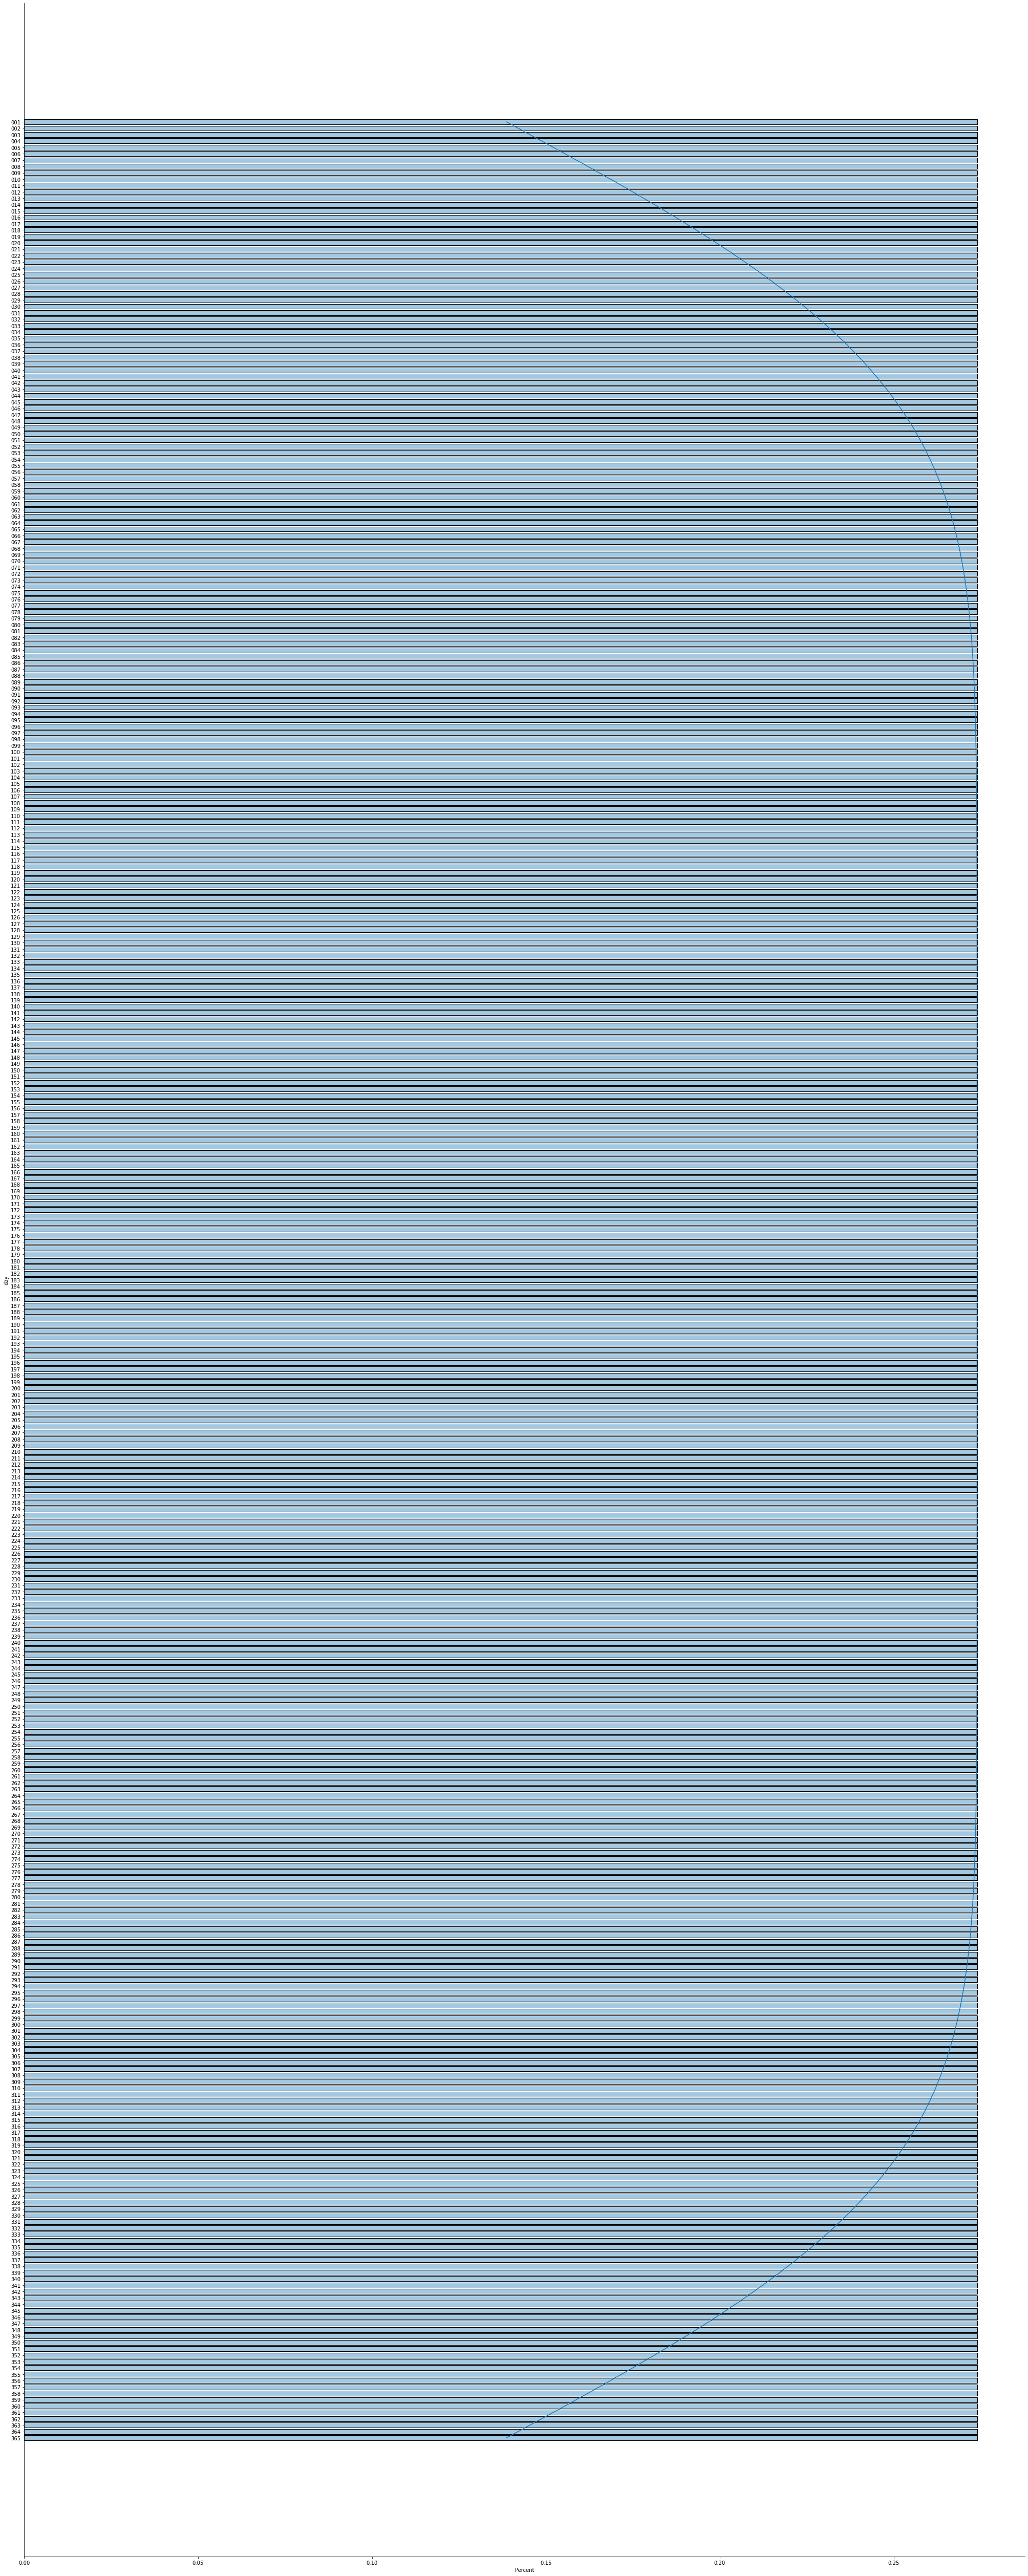

In [24]:
import seaborn as sns
g = sns.displot(
    data=all_orders_grpday_statecount,
    kind='hist',
    #x='completed',
    y='day', 
    alpha=.4, # add transparency to you chart
    #multiple="stack",
    element='bars',
    stat='percent',
    shrink=.8,
    kde=True, # add a density line in the histogram
    height=70,
    aspect=.4
)